<a href="https://colab.research.google.com/github/yinhao0424/reuters/blob/master/ReustersMultilabelClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Multilabel Classification on Reusters News with DistilBert

In this notebook, I will train a transformer model for the Multilabel text classification problem.
#### Data:
- The data is reusters21578 dataset
- The data is preprocessed to groupe 135 topics into 9 categories, which are:
  - money-fx
  - ship
  - interest
  - economic_indicator
  - currency
  - commodity
  - energy
  - acq
  - earn

#### Language Model
- Reference: 
  - Paper: 
    - [Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805) 
   - [DistilBERT, a distilled version of BERT](https://arxiv.org/pdf/1910.01108.pdf)
  - Blog:
   - [Transformers Tutorial](https://huggingface.co/transformers/notebooks.html)
   - [Introducing DistilBERT, a distilled version of BERT](https://medium.com/huggingface/distilbert-8cf3380435b5)
   - [Cost-Sensitive BERT for Generalisable Sentence Classification with Imbalanced Data](https://deepai.org/publication/cost-sensitive-bert-for-generalisable-sentence-classification-with-imbalanced-data )
  - Github: 
    - [Transformers](https://github.com/huggingface/transformers/blob/master/notebooks/02-transformers.ipynb)
    - [Fine Tuning Transformer for MultiLabel Text Classification](https://github.com/abhimishra91/transformers-tutorials/blob/master/transformers_multi_label_classification.ipynb)


In [1]:
# a specific version of transformaer has been used 
! pip install -q transformers==3.0.2

     |████████████████████████████████| 778kB 8.1MB/s 
     |████████████████████████████████| 890kB 36.2MB/s 
     |████████████████████████████████| 3.0MB 45.0MB/s 
     |████████████████████████████████| 1.2MB 42.5MB/s 


In [2]:
! nvidia-smi

Mon Jan 11 17:38:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import numpy as np
import pandas as pd
from sklearn import metrics
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertTokenizer, DistilBertModel

import warnings
warnings.simplefilter('ignore')
import logging
logging.basicConfig(level=logging.ERROR)

In [4]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
device

device(type='cuda')

In [5]:
# Prepare Training Data
train_data = pd.read_csv("/content/drive/MyDrive/data/reuters/reuters_multilabel_train.csv")

# convert labels to list
from ast import literal_eval
train_data.labels = train_data.labels.apply(literal_eval)

# extract texts and labels
train_data = train_data[['texts','labels']].copy()

train_data.head()

,texts,labels
0,u.s. economic data key to debt futures outlook...,"[0, 0, 1, 1, 0, 0, 0, 0, 0]"
1,bank of british columbia 1st qtr jan 31 netope...,"[0, 0, 0, 0, 0, 0, 0, 0, 1]"
2,restaurant associates inc <ra> 4th qtr jan 3sh...,"[0, 0, 0, 0, 0, 0, 0, 0, 1]"
3,michigan general corp <mgl> 4th qtrshr loss 1....,"[0, 0, 0, 0, 0, 0, 0, 0, 1]"
4,"usx <x> proved oil, gas reserves fall in 1986u...","[0, 0, 0, 0, 0, 1, 1, 0, 0]"


In [6]:
# Parse Testing Data
test_data = pd.read_csv("/content/drive/MyDrive/data/reuters/reuters_multilabel_test.csv")

# convert labels to list
from ast import literal_eval
test_data.labels = test_data.labels.apply(literal_eval)

# extract texts and labels
test_data = test_data[['texts','labels']].copy()

test_data.head()

,texts,labels
0,hospital corp says it received 47 dlr a share ...,"[0, 0, 0, 0, 0, 0, 0, 1, 0]"
1,beverly enterprises <bev> sets regular dividen...,"[0, 0, 0, 0, 0, 0, 0, 0, 1]"
2,treasury's baker says floating exchange rate s...,"[1, 0, 0, 0, 0, 0, 0, 0, 0]"
3,"crude oil netbacks up sharply in europe, u.s.c...","[0, 0, 0, 0, 0, 0, 1, 0, 0]"
4,treasury's baker says system needs stabilitytr...,"[1, 0, 0, 0, 0, 0, 0, 0, 0]"


### Preparing the Dataset and Dataloader


In [7]:
# Sections of config
# Defining some key variables that will be used later on in the training
MAX_LEN = 200
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
EPOCHS = 2
LEARNING_RATE = 1e-05
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)

In [8]:
class MultiLabelDataset(Dataset):
#   map-style datasets: a dataset, when accessed with dataset[idx], could read the idx-th image 
#   and its corresponding label from a folder on the disk.
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.texts
        self.targets = self.data.labels
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [9]:
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

training_set = MultiLabelDataset(train_data, tokenizer, MAX_LEN)
testing_set = MultiLabelDataset(test_data, tokenizer, MAX_LEN)

TRAIN Dataset: (7775, 2)
TEST Dataset: (3019, 2)


In [10]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 1
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 1
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

### Creating the Neural Network for Fine Tuning

In [11]:
class DistilBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistilBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(768, 9)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.Tanh()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

model = DistilBERTClass()
model.to(device)

DistilBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_featu

In [12]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [13]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [14]:
def train(EPOCHS):
    train_losses = []
    for epoch in range(EPOCHS):
      running_loss = 0
      model.train()
      for _,data in tqdm(enumerate(training_loader, 0)):
          ids = data['ids'].to(device, dtype = torch.long)
          mask = data['mask'].to(device, dtype = torch.long)
          token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
          targets = data['targets'].to(device, dtype = torch.float)

          outputs = model(ids, mask, token_type_ids)

          optimizer.zero_grad()
          loss = loss_fn(outputs, targets)
          
          if _%200==0:
              print(f'Epoch: {epoch}, Loss:  {loss.item()}')
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          # running_loss = loss.item()
          # avg_train_loss = running_loss / len(training_loader)
          avg_train_loss = loss.item() / TRAIN_BATCH_SIZE
          train_losses.append(avg_train_loss)

      # train_losses.append(loss.item())
    return train_losses



In [15]:
train_losses = train(EPOCHS)


1it [00:00,  2.47it/s]

Epoch: 0, Loss:  0.7022190093994141


201it [00:30,  6.46it/s]

Epoch: 0, Loss:  0.18297375738620758


401it [01:02,  6.14it/s]

Epoch: 0, Loss:  0.14642490446567535


601it [01:36,  5.88it/s]

Epoch: 0, Loss:  0.061591438949108124


801it [02:10,  5.71it/s]

Epoch: 0, Loss:  0.14559705555438995


972it [02:40,  6.07it/s]
1it [00:00,  5.03it/s]

Epoch: 1, Loss:  0.02594984509050846


201it [00:34,  5.76it/s]

Epoch: 1, Loss:  0.0848860889673233


401it [01:09,  5.76it/s]

Epoch: 1, Loss:  0.017704881727695465


601it [01:43,  5.73it/s]

Epoch: 1, Loss:  0.03750481829047203


801it [02:18,  5.71it/s]

Epoch: 1, Loss:  0.01588706485927105


972it [02:48,  5.78it/s]


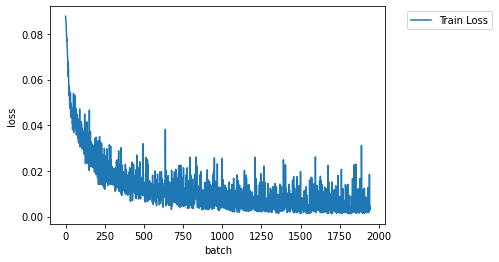

In [16]:

#plotting of training loss
plt.xlabel('batch')
plt.ylabel('loss')
plt.plot(train_losses, label='Train Loss')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [24]:
def validation(testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    val_losses = []
    running_loss = 0.0
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            optimizer.zero_grad()
            loss = loss_fn(outputs, targets)
            running_loss = loss.item()
            # avg_train_loss = running_loss / len(training_loader)
            avg_train_loss = running_loss / VALID_BATCH_SIZE 
            val_losses.append(avg_train_loss)

            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets,val_losses

In [25]:
outputs, targets,val_losses = validation(testing_loader)

final_outputs = np.array(outputs) >=0.5

755it [00:23, 32.63it/s]


In [27]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [28]:

accuracy = metrics.accuracy_score(targets, final_outputs)
f1_score_micro = metrics.f1_score(targets, final_outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, final_outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.9105664127194435
F1 Score (Micro) = 0.9436377829820454
F1 Score (Macro) = 0.8946771995749994


In [29]:
val_hamming_loss = metrics.hamming_loss(targets, final_outputs)
val_hamming_score = hamming_score(np.array(targets), np.array(final_outputs))

print(f"Hamming Score = {val_hamming_score}")
print(f"Hamming Loss = {val_hamming_loss}")

Hamming Score = 0.9375069007397594
Hamming Loss = 0.013286224283243164


In [30]:

output_model_file = '/content/drive/MyDrive/data/reuters/pytorch_distilbert_news.bin'
output_vocab_file = '/content/drive/MyDrive/data/reuters/vocab_distilbert_news.bin'

torch.save(model, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('Saved')

Saved
